In [11]:
# Music classification by genre - local notebook
import tensorflow as tf
from tensorflow.contrib.data import Dataset, Iterator
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import os

In [12]:
# Our music genre labels
label_dict = {
    'Classical': 0,
    'Techno': 1,
    'Pop': 2,
    'HipHop': 3,
    'Metal': 4,
    'Rock': 5
}

NUM_CLASSES = label_dict.__len__()

In [2]:
import pydoop

ImportError: No module named pydoop

In [13]:
def input_parser(img_path, label_value):
    label = tf.one_hot(label_value, NUM_CLASSES)
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_image(img_file, channels=1)

    return img_decoded, label

In [14]:
def load_and_shuffle_data(data_folder):
    data = []
    for file in glob.glob("data/" + data_folder + "/*/**.png"):
        # extract label
        filename = file.split("/")[len(file.split("/")) - 1]
        genre = filename.split("_")[0]

        # if we can't extract the label from the image we should not train on it
        if genre not in label_dict:
            print("err " + genre)
            continue;
        
        label_val = label_dict.get(genre)
        data.append((file, label_val))
    
    random.shuffle(data)
    image_paths = [x[0] for x in data]
    labels = [x[1] for x in data]
    
    return image_paths, labels

In [15]:
# Load train data
train_images, train_labels = load_and_shuffle_data('train2')

# create TensorFlow Dataset objects
tf_train_data = Dataset.from_tensor_slices((train_images, train_labels))
tf_train_data = tf_train_data.map(input_parser)    

In [16]:
# Load test data
test_images, test_labels = load_and_shuffle_data('train')

# create TensorFlow Dataset objects
tf_test_data = Dataset.from_tensor_slices((test_images, test_labels))
tf_test_data = tf_test_data.map(input_parser)  

label:[ 0.  1.  0.  0.  0.  0.]


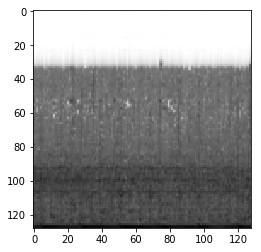

In [17]:
# validate our data, plot first element
# create TensorFlow Iterator object
iterator = Iterator.from_structure(tf_train_data.output_types, tf_train_data.output_shapes)
next_element = iterator.get_next()

# create two initialization ops to switch between the datasets
training_init_op = iterator.make_initializer(tf_train_data)

with tf.Session() as sess:
    # initialize the iterator on the data
    sess.run(training_init_op)
    elem = sess.run(next_element)
    print("label:" + str(elem[1]))
    two_d_image = elem[0].reshape(128, 128)
    plt.imshow(two_d_image, cmap='Greys')
    plt.show()

In [18]:
batch_data = tf_train_data.batch(100)
iterator = batch_data.make_one_shot_iterator()
train_images, train_labels = iterator.get_next()

with tf.Session() as sess:
    tl = train_labels.eval()
    print(tl.size)

600


In [ ]:
def cnn_with_hyperparameters(dropout, starter_learning_rate):
    # 1. Define Variables and Placeholders
    X = tf.placeholder(tf.float32, [None, 128, 128, 1]) # The first dimension (None) will index the images
    Y_ = tf.placeholder(tf.float32, [None, 6])          # Correct answers
    
    # placeholder for probability of keeping a node during dropout
    pkeep = tf.placeholder(tf.float32)
    
    # Convolutional layers
    CL1W = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
    CL1B = tf.Variable(tf.constant(0.1, shape=[4]))
    CL2W = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
    CL2B = tf.Variable(tf.constant(0.1, shape=[8]))
    CL3W = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
    CL3B = tf.Variable(tf.constant(0.1, shape=[12]))
    
    # Fully connected layer
    # We should have 12 32*32 images, one for each feature
    FCW = tf.Variable(tf.truncated_normal([32 * 32 * 12, 200], stddev=0.1))
    FCB = tf.Variable(tf.zeros([200]))
    
    # Read out layer
    ROW = tf.Variable(tf.truncated_normal([200, 6], stddev=0.1))
    ROB = tf.Variable(tf.zeros([6]))
    
    # Convolutional and ReLU layers
    CL1 = tf.nn.conv2d(X, CL1W, strides=[1, 1, 1, 1], padding='SAME')
    Y1 = tf.nn.relu(CL1 + CL1B)
    Y1d = tf.nn.dropout(Y1, pkeep)
    CL2 = tf.nn.conv2d(Y1d, CL2W, strides=[1, 2, 2, 1], padding='SAME')
    Y2 = tf.nn.relu(CL2 + CL2B)
    Y2d = tf.nn.dropout(Y2, pkeep)
    CL3 = tf.nn.conv2d(Y2d, CL3W, strides=[1, 2, 2, 1], padding='SAME')
    Y3 = tf.nn.relu(CL3 + CL3B)
    Y3d = tf.nn.dropout(Y3, pkeep)
    
    # Fully connected layer
    # Reshape to vector
    # Y3.shape = (?, 32, 32, 12)
    #Y3RS = tf.reshape(Y3, [-1, 128 * 128 * 1])
    Y3RS = tf.reshape(Y3d, [-1, 32 * 32 * 12])
    Y4 = tf.nn.relu(tf.matmul(Y3RS, FCW) + FCB)
    
    # Read out layer
    Ylogits = tf.matmul(Y4, ROW) + ROB
    Y = tf.nn.softmax(Ylogits)
    
    # 3. Define the loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)
    
    # 4. Define the accuracy
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 5. Define an optimizer - Gradient Descent Optimizer or Adam Optimizer

    # https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay
    global_step = tf.Variable(0, trainable=False)
    # decay every 100 steps with a base of 0.96
    decay_steps = 100
    decay_rate = 0.96
    # If the argument staircase is True, then global_step / decay_steps is an integer division 
    # and the decayed learning rate follows a staircase function.
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, 
        global_step, 
        decay_steps, 
        decay_rate, 
        staircase=True)

    # Note: Passing global_step to minimize() will increment it at each step.
    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
    
    # initialize
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    
    # training data iterator
    batch_data = tf_train_data.batch(100)
    #training_iterator = batch_data.make_one_shot_iterator()
    
    # TEST : reinitializable iterator
    train_iterator = tf.data.Iterator.from_structure(batch_data.output_types, batch_data.output_shapes)
    train_iterator_init_op = train_iterator.make_initializer(batch_data)
    sess.run(train_iterator_init_op)
        
    # get all test data
    all_test_data = tf_test_data.batch(450)
    test_iterator = all_test_data.make_one_shot_iterator()
    test_images, test_labels = test_iterator.get_next()

    test_images = sess.run(test_images)
    test_labels = sess.run(test_labels)
    
    def training_step(i, update_test_data, update_train_data, dropout):

        print "\r", i,
        ####### actual learning 
        
        #batch_X, batch_Y = training_iterator.get_next()
        #batch_X = sess.run(batch_X)
        #batch_Y = sess.run(batch_Y)
        
        try:
            batch_X, batch_Y = train_iterator.get_next()
            batch_X = sess.run(batch_X)
            batch_Y = sess.run(batch_Y)
        except tf.errors.OutOfRangeError:
            print("Train data out of range")
            sess.run(train_iterator_init_op)
            batch_X, batch_Y = train_iterator.get_next()
            batch_X = sess.run(batch_X)
            batch_Y = sess.run(batch_Y)
        
        
        #print(batch_X.shape)
        # the backpropagation training step
        sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep: dropout})

        ####### evaluating model performance for printing purposes
        # evaluation used to later visualize how well you did at a particular time in the training
        train_a = []
        train_c = []
        test_a = []
        test_c = []
        if update_train_data:
            a, c = sess.run([accuracy, cross_entropy], feed_dict=
                            {X: batch_X, Y_: batch_Y, pkeep: 1})
            train_a.append(a)
            train_c.append(c)

        if update_test_data:
            a, c = sess.run([accuracy, cross_entropy], feed_dict=
                            {X: test_images, Y_: test_labels,  pkeep: 1})
            test_a.append(a)
            test_c.append(c)

        return (train_a, train_c, test_a, test_c)
    
    # 6. Train and test the model, store the accuracy and loss per iteration
    train_a = []
    train_c = []
    test_a = []
    test_c = []

    training_iter = 250
    epoch_size = 10
    for i in range(training_iter):
        test = False
        if i % epoch_size == 0:
            test = True
        a, c, ta, tc = training_step(i, test, test, dropout)
        train_a += a
        train_c += c
        test_a += ta
        test_c += tc
        
    # 7. Plot and visualise the accuracy and loss
    # accuracy training vs testing dataset
    plt.plot(train_a)
    plt.plot(test_a)
    plt.grid(True)
    plt.show()

    # loss training vs testing dataset
    plt.plot(train_c)
    plt.plot(test_c)
    plt.grid(True)
    plt.show()

    # Zoom in on the tail of the plots
    zoom_point = 50
    x_range = range(zoom_point,training_iter/epoch_size)
    plt.plot(x_range, train_a[zoom_point:])
    plt.plot(x_range, test_a[zoom_point:])
    plt.grid(True)
    plt.show()

    plt.plot(train_c[zoom_point:])
    plt.plot(test_c[zoom_point:])
    plt.grid(True)
    plt.show()
    
    
    # Accuracy
    print(sess.run(accuracy, feed_dict={X: test_images, Y_: test_labels, pkeep: 1}))

In [ ]:
cnn_with_hyperparameters(0.5, 0.001)

90                                                                                         